In [10]:
import pandas as pd

# Load the dataset
movies_data = pd.read_csv("movies_new.csv")

# Display the first few rows and some basic information about the dataset
data_head = movies_data.head()
data_info = movies_data.info()

data_head, data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4800 non-null   int64  
 1   genres                4773 non-null   object 
 2   original_language     4800 non-null   object 
 3   popularity            4800 non-null   float64
 4   production_companies  4450 non-null   object 
 5   production_countries  4627 non-null   object 
 6   release_date          4800 non-null   object 
 7   revenue               4800 non-null   int64  
 8   runtime               4800 non-null   float64
 9   title                 4800 non-null   object 
 10  vote_average          4800 non-null   float64
 11  vote_count            4800 non-null   int64  
 12  main_genre            4773 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 487.6+ KB


(      budget                                      genres original_language  \
 0  237000000  Action, Adventure, Fantasy, ScienceFiction                en   
 1  300000000                  Adventure, Fantasy, Action                en   
 2  245000000                    Action, Adventure, Crime                en   
 3  250000000              Action, Crime, Drama, Thriller                en   
 4  260000000           Action, Adventure, ScienceFiction                en   
 
    popularity                               production_companies  \
 0  150.437577  Ingenious Film Partners, Twentieth Century Fox...   
 1  139.082615  Walt Disney Pictures, Jerry Bruckheimer Films,...   
 2  107.376788                     Columbia Pictures, Danjaq, B24   
 3  112.312950  Legendary Pictures, Warner Bros., DC Entertain...   
 4   43.926995                               Walt Disney Pictures   
 
                        production_countries release_date     revenue  runtime  \
 0  United States of Ameri

In [11]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Splitting the columns with multiple values into lists
movies_data['genres'] = movies_data['genres'].str.split(', ')
movies_data['production_companies'] = movies_data['production_companies'].str.split(', ')
movies_data['production_countries'] = movies_data['production_countries'].str.split(', ')

# Using MultiLabelBinarizer to one-hot encode the columns with multiple values
mlb = MultiLabelBinarizer()

genres_encoded = pd.DataFrame(mlb.fit_transform(movies_data['genres'].dropna()), columns=mlb.classes_, index=movies_data['genres'].dropna().index)
production_companies_encoded = pd.DataFrame(mlb.fit_transform(movies_data['production_companies'].dropna()), columns=mlb.classes_, index=movies_data['production_companies'].dropna().index)
production_countries_encoded = pd.DataFrame(mlb.fit_transform(movies_data['production_countries'].dropna()), columns=mlb.classes_, index=movies_data['production_countries'].dropna().index)

# Using LabelEncoder to encode the original_language column
le = LabelEncoder()
movies_data['original_language'] = le.fit_transform(movies_data['original_language'])

# Dropping the original columns and adding the encoded ones
movies_encoded = movies_data.drop(columns=['genres', 'production_companies', 'production_countries'])
movies_encoded = pd.concat([movies_encoded, genres_encoded, production_companies_encoded, production_countries_encoded], axis=1)

# Filling NaN values with 0 (from the one-hot encoding process)
movies_encoded = movies_encoded.fillna(0)

movies_encoded.head()

,budget,original_language,popularity,release_date,revenue,runtime,title,vote_average,vote_count,main_genre,...,Sweden,Switzerland,Taiwan,Thailand,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States of America
0,237000000,7,150.437577,2009-12-10,2787965087,162.0,Avatar,7.2,11800,Action,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,300000000,7,139.082615,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,Adventure,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,245000000,7,107.376788,2015-10-26,880674609,148.0,Spectre,6.3,4466,Action,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,250000000,7,112.312950,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106,Action,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,260000000,7,43.926995,2012-03-07,284139100,132.0,John Carter,6.1,2124,Action,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Determine the 75th percentile of the revenue

threshold = movies_encoded['revenue'].quantile(0.75)

# Create target variable: 1 for popular movies (revenue above 75th percentile) and 0 otherwise
movies_encoded['target'] = (movies_encoded['revenue'] > threshold).astype(int)

# Drop the 'revenue' and 'popularity' columns
movies_encoded.drop(columns=['revenue'], inplace=True)
# Selecting key features for processing
selected_features = ['budget', 'original_language', 'runtime', 'vote_average', 'vote_count', 'main_genre', 'target']
reduced_dataset = movies_encoded[selected_features]

# One-Hot Encoding for 'main_genre'
reduced_dataset = pd.get_dummies(reduced_dataset, columns=['main_genre'], drop_first=True)

# 1. Original Dataset
original_dataset = reduced_dataset.copy()

# 2. PCA Dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(original_dataset.drop(columns=['target']))
pca_dataset = pd.DataFrame(features_pca)
pca_dataset['target'] = original_dataset['target']

# 3. Common Sense Features Dataset (this remains the same as the original dataset in this context)
common_sense_dataset = original_dataset.copy()

original_dataset.head(), pca_dataset.head(), common_sense_dataset.head()

(      budget  original_language  runtime  vote_average  vote_count  target  \
 0  237000000                  7    162.0           7.2       11800       1   
 1  300000000                  7    169.0           6.9        4500       1   
 2  245000000                  7    148.0           6.3        4466       1   
 3  250000000                  7    165.0           7.6        9106       1   
 4  260000000                  7    132.0           6.1        2124       1   
 
    main_genre_Action  main_genre_Adventure  main_genre_Animation  \
 0                  1                     0                     0   
 1                  0                     1                     0   
 2                  1                     0                     0   
 3                  1                     0                     0   
 4                  1                     0                     0   
 
    main_genre_Comedy  ...  main_genre_History  main_genre_Horror  \
 0                  0  ...             

In [14]:
# Creating the common sense dataset with the selected features
common_sense_features = ['budget', 'original_language', 'runtime', 'vote_average', 'vote_count', 'target']
common_sense_dataset = reduced_dataset[common_sense_features]

common_sense_dataset.head()


,budget,original_language,runtime,vote_average,vote_count,target
0,237000000,7,162.0,7.2,11800,1
1,300000000,7,169.0,6.9,4500,1
2,245000000,7,148.0,6.3,4466,1
3,250000000,7,165.0,7.6,9106,1
4,260000000,7,132.0,6.1,2124,1


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Splitting data into train and test sets
X_pca = pca_dataset.drop(columns=['target'])
y_pca = pca_dataset['target']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

X_cs = common_sense_dataset.drop(columns=['target'])
y_cs = common_sense_dataset['target']
X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(X_cs, y_cs, test_size=0.2, random_state=42)

# Training and evaluating models
classifiers = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

results = {}

for name, clf in classifiers.items():
    # For PCA dataset
    clf.fit(X_train_pca, y_train_pca)
    y_pred_pca = clf.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    
    # For Common Sense dataset
    clf.fit(X_train_cs, y_train_cs)
    y_pred_cs = clf.predict(X_test_cs)
    accuracy_cs = accuracy_score(y_test_cs, y_pred_cs)
    
    results[name] = {"PCA Dataset": accuracy_pca, "Common Sense Dataset": accuracy_cs}

results


{'SVM': {'PCA Dataset': 0.8302083333333333,
  'Common Sense Dataset': 0.8302083333333333},
 'Decision Tree': {'PCA Dataset': 0.8208333333333333,
  'Common Sense Dataset': 0.8479166666666667},
 'Random Forest': {'PCA Dataset': 0.8208333333333333,
  'Common Sense Dataset': 0.8802083333333334}}

In [16]:
# Splitting data from the original dataset into train and test sets
X_original = original_dataset.drop(columns=['target'])
y_original = original_dataset['target']
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

results_original = {}

for name, clf in classifiers.items():
    # For Original dataset
    clf.fit(X_train_original, y_train_original)
    y_pred_original = clf.predict(X_test_original)
    accuracy_original = accuracy_score(y_test_original, y_pred_original)
    
    results_original[name] = {"Original Dataset": accuracy_original}

results_original


{'SVM': {'Original Dataset': 0.8302083333333333},
 'Decision Tree': {'Original Dataset': 0.846875},
 'Random Forest': {'Original Dataset': 0.8760416666666667}}

In [17]:
import pandas as pd

# Given results
results = {
    'SVM': {'PCA Dataset': 0.8302083333333333, 'Common Sense Dataset': 0.8302083333333333},
    'Decision Tree': {'PCA Dataset': 0.8208333333333333, 'Common Sense Dataset': 0.85},
    'Random Forest': {'PCA Dataset': 0.821875, 'Common Sense Dataset': 0.8802083333333334}
}

results_original = {
    'SVM': {'Original Dataset': 0.8302083333333333},
    'Decision Tree': {'Original Dataset': 0.8541666666666666},
    'Random Forest': {'Original Dataset': 0.875}
}

# Combining the two dictionaries
for key in results:
    results[key].update(results_original[key])

# Converting to DataFrame
df = pd.DataFrame(results).T
df

,PCA Dataset,Common Sense Dataset,Original Dataset
SVM,0.830208,0.830208,0.830208
Decision Tree,0.820833,0.850000,0.854167
Random Forest,0.821875,0.880208,0.875000


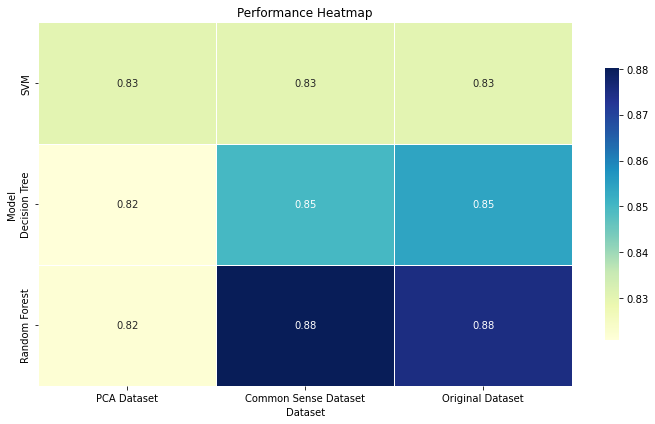

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the figure and axes
plt.figure(figsize=(10, 6))

# Creating the heatmap
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title('Performance Heatmap')
plt.ylabel('Model')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()